In [1]:
pokemon<-read.csv("../data/pokemon.csv",sep=",",stringsAsFactors=F, header = TRUE)
combats<-read.csv("../data/combats.csv",sep=",",stringsAsFactors=F, header = TRUE)
source("../fonctions/distXY.R")
source("../fonctions/kppv.val.R")
source("../fonctions/separ2.R")


In [8]:
distXY <- function(X, Y) {
    nx <- dim(X)[1]
    ny <- dim(Y)[1]
    h.x <- rowSums(X^2)
    h.y <- rowSums(Y^2)
    ones.x <- rep(1, nx)
    ones.y <- rep(1, ny)
    D2xy <- h.x %*% t(ones.y) - 2 * X %*% t(Y) + ones.x %*% t(h.y)
}


separ2 <- function(X, z)
{
  ntot <- dim(X)[1]

  iapp <- sample(1:ntot, round(1/2*ntot))
  ival <- sample(setdiff(1:ntot,iapp), round(1/4*ntot))
  itst <- setdiff(1:ntot, c(iapp,ival))

  Xapp <- X[iapp,]
  zapp <- z[iapp]
  Xval <- X[ival,]
  zval <- z[ival]
  Xtst <- X[itst,]
  ztst <- z[itst]

  out <- NULL
  out$Xapp <- Xapp
  out$zapp <- zapp
  out$Xval <- Xval
  out$zval <- zval
  out$Xtst <- Xtst
  out$ztst <- ztst

  out
}

kppv.tune <- function(Xapp, zapp, Xval, zval, nppv)
{
	taux <- rep(0,length(nppv))
  

	for (k in nppv)
	{
    z_pred<-kppv.val(Xapp,zapp,k,Xval)
    taux[k]<-mean(zval==z_pred)
	}

 
 

 out$k <- which.max(taux)  #On renvoit l'indice de la table qui a le taux maximal, c'est donc le Kopt
 out$taux <-taux[which.max(taux)]
 
 out
}


kppv.val <- function(Xapp, zapp, K, Xtst)
{
	Xapp <- as.matrix(Xapp)
	Xtst <- as.matrix(Xtst)#On s'assure que ce sont des matrices

	napp <- dim(Xapp)[1]
	ntst <- dim(Xtst)[1]
	p <- dim(Xapp)[2]#Nombres de descripteurs

	# calcul des distances 
	d2 <- distXY(Xtst, Xapp)         #Table napp x ntst
	d2sor <- t(apply(d2, 1, sort))   #On trie chaque ligne par ordre croissant (de l'ex de test le plus proche au plus éloigné)
                                    #Attention, le apply renvoie la transposée
	
	# distance seuil pour chaque individu de l'ensemble 
	# de test (distance a son Kieme plus proche voisin) 
	seuil <- d2sor[,K] 

	# identification des plus proches voisins 
	is.ppv <- (d2<=matrix(rep(seuil,napp),nrow=ntst,byrow=F)) #Tableau de booléens qui renvoie si on est en dessous du seuil
                                                            #TRUE = c'est un point voisin
	
  # valeur de f pour les K plus proches voisins
  z.kppv <- matrix(rep(as.numeric(zapp),ntst),nrow=ntst,byrow=T)*is.ppv #On multiplie par le masque

  g <- nlevels(zapp)
  scores <- matrix(0,nrow=ntst,ncol=g)
  for (k in 1:g)
	{
		scores[,k] <- apply(z.kppv==k,1,sum) #On compte les occurences du nombre k pour chacune des lignes
		                                
  }

  # classement dans la classe majoritaire 
  zpred <- as.factor(apply(scores, 1, which.max))   #L'index du maximum est la classe DONC on peut utiliser which.max
}

#on pourrait renvoyer le % d'occurence de la classe dans les k voisins


[1] 0.060 0.075 0.060 0.070 0.065 0.075 0.080 0.075 0.055 0.065

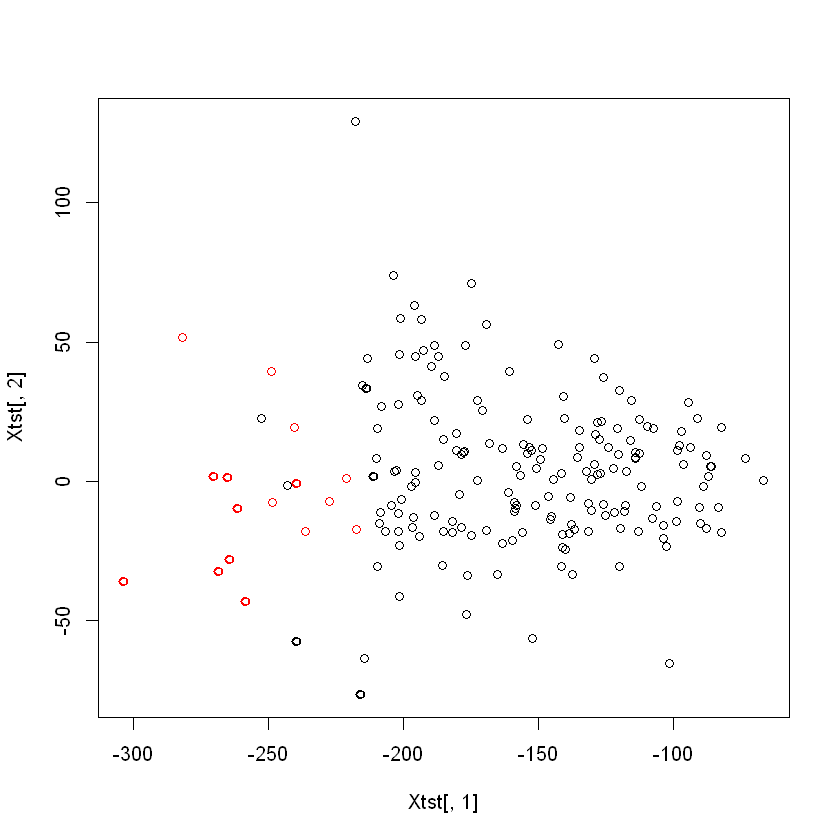

In [35]:
#A partir de l'ACP, on remarque que l'on peut globalement expliquer l'inertie du nuage à partir des composantes 1 et 2

pokemon<-read.csv("../data/pokemon.csv",sep=",",stringsAsFactors=F, header = TRUE)
combats<-read.csv("../data/combats.csv",sep=",",stringsAsFactors=F, header = TRUE)
pokemon$Legendary <- as.numeric(as.logical(pokemon$Legendary)) + 1

pokemon.num<-pokemon[c(5,6,7,8,9)]
ACP<-princomp(pokemon.num)

a <- list(as.vector(as.numeric(pokemon$Legendary)),"red")
class(a) <- append(class(a),"myclass")
'[.myclass' <- function(x,i) x[[i]]

#biplot(princomp(pokemon.num), col = a,choices=c(1,2)) 
#biplot(princomp(pokemon.num), col = a,choices=c(1,3)) 


V1 <- as.matrix(pokemon.num)%*% as.matrix(ACP$loadings[,1])
V2 <- as.matrix(pokemon.num)%*% as.matrix(ACP$loadings[,2])
X <-cbind (V1,V2,pokemon$Legendary)

#plot(V1,V2,col = pokemon$Legendary )
E<-rep(0,10)
for (i in 1:10)
    {
        out<-separ2(X[,1:2],X[,3])
        Xapp<-out$Xapp
        zapp<-out$zapp
        Xval<-out$Xval
        zval<-out$zval
        Xtst<-out$Xtst
        ztst<-out$ztst

        Kopt<-kppv.tune(Xapp, as.factor(zapp), Xval, as.factor(zval), seq(from=1,to=20,by=2))
        z_predit<-kppv.val(Xapp,as.factor(zapp),Kopt$k,Xtst) 

        E[i]<-mean(z_predit!=ztst)
   }

E #Erreur
plot(Xtst[,1],Xtst[,2],col= z_predit,lwd=ztst)